In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout

import json
import matplotlib.pyplot as plt

# Carga de datos

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("validation.csv")
char_to_pred = json.load(open("data/character_to_prediction_index.json", "r"))

In [3]:
train_data.head()

,sequence_id,target
0,1,bathroom
1,1,bathroom
2,1,bathroom
3,1,bathroom
4,1,bathroom


# Analisis Exploratorio

In [4]:
print("--------------------Train data--------------------")
print(f"Cantidad de filas : {train_data.shape[0]}")
print(f"Frases unicas : {train_data.target.unique()}")

--------------------Train data--------------------
Cantidad de filas : 4925
Frases unicas : ['bathroom' 'cat' 'dog' 'eat food' 'father' 'fine' 'finish' 'go to'
 'hello' 'help' 'learn' 'like' 'me' 'milk' 'more' 'mother' 'no' 'please'
 'repeat' 'see you later' 'sign' 'thank you' 'want' 'what' 'yes']


In [5]:
print("--------------------Validation data--------------------")
print(f"Cantidad de filas : {test_data.shape[0]}")
print(f"Frases unicas : {test_data.target.unique()}")

--------------------Validation data--------------------
Cantidad de filas : 356
Frases unicas : ['bathroom' 'cat' 'dog' 'eat food' 'father' 'fine' 'finish' 'go to'
 'hello' 'help' 'learn' 'like' 'me' 'milk' 'more' 'mother' 'no' 'please'
 'repeat' 'see you later' 'sign' 'thank you' 'want' 'what' 'yes']


In [6]:
if (list(train_data.target.unique()) != list(test_data.target.unique())):
    raise ValueError("Error between target and train")

In [7]:
train_data.describe()

,sequence_id
count,4925.000000
mean,178.241827
std,105.238701
min,1.000000
25%,84.000000
50%,185.000000
75%,267.000000
max,359.000000


# Levenshtein Distance
* Ref: https://blog.paperspace.com/implementing-levenshtein-distance-word-autocomplete-autocorrect/#:~:text=The%20Levenshtein%20distance%20is%20a,transform%20one%20word%20into%20another.

In [8]:
def printDistances(distances, token1Length, token2Length):
    for t1 in range(token1Length + 1):
        for t2 in range(token2Length + 1):
            print(int(distances[t1][t2]), end=" ")
        print()

def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    printDistances(distances, len(token1), len(token2))
    return distances[len(token1)][len(token2)]

In [9]:
# levenshteinDistanceDP("kelm", "hello")

# Preprocesamiento del Modelo

Solo se obtienen 20 indices de las coordenadas x y y, ya que son las unicas que han sido altamente entrenadas del modelo mediapipe de Google

In [10]:
def get_needed_cols():
    cols = []

    for i in range(21):
        cols.append(f'x_right_hand_{i}')
        cols.append(f'y_right_hand_{i}')
        cols.append(f'x_left_hand_{i}')
        cols.append(f'y_left_hand_{i}')
    
    return cols

In [11]:
df = pd.read_csv("data.csv")
df_test = df[df['sequence_id'].isin(test_data['sequence_id'])]
df_train = df[df['sequence_id'].isin(train_data['sequence_id'])]

In [12]:
df.head()

,sequence_id,target,x_right_hand_0,x_right_hand_1,x_right_hand_10,x_right_hand_11,x_right_hand_12,x_right_hand_13,x_right_hand_14,x_right_hand_15,...,y_left_hand_19,y_left_hand_2,y_left_hand_20,y_left_hand_3,y_left_hand_4,y_left_hand_5,y_left_hand_6,y_left_hand_7,y_left_hand_8,y_left_hand_9
0,1,bathroom,0.265100,0.292266,0.289448,0.293812,0.295057,0.267202,0.275095,0.279875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,bathroom,0.259819,0.283851,0.270306,0.277417,0.281006,0.252090,0.258523,0.266719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,bathroom,0.259433,0.278479,0.252867,0.263265,0.270317,0.239482,0.243582,0.254479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,bathroom,0.262010,0.274468,0.239758,0.253949,0.263418,0.230673,0.232797,0.246966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,bathroom,0.268236,0.273854,0.231170,0.247891,0.259833,0.226620,0.228386,0.245820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
print(len(df))
print(len(df_test) == len(test_data))
print(len(df_train) == len(train_data))

5281
True
True


# Modelo

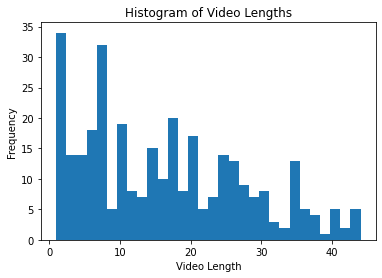

In [14]:
# Compute the lengths of the video sequences
video_lengths = df.groupby('sequence_id').size()
max_seq_length = video_lengths.max()
# max_seq_length = 30
# Plot the histogram
plt.hist(video_lengths, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Video Length')
plt.ylabel('Frequency')
plt.title('Histogram of Video Lengths')
plt.show()

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# Create a one-hot encoder
label_encoder = LabelEncoder()

In [16]:
def padding_videos(df):
    # Create a new DataFrame to store the filled rows
    filled_df = pd.DataFrame()
    target = []


    # Iterate over each group and fill remaining rows with zero
    for _, group in df.groupby('sequence_id'):
        remaining_rows = max_seq_length - len(group)
        if remaining_rows > 0:
            zeros_df = pd.DataFrame([[0] * len(group.columns)] * remaining_rows, columns=group.columns)
            zeros_df['sequence_id'] = group['sequence_id'].unique()[0]
            zeros_df['target'] = group['target'].unique()[0]
            group = pd.concat([group, zeros_df])
        
            filled_df = filled_df.append(group)
            target.append(group["target"].unique()[0])
        
    filled_df.reset_index(drop=True, inplace=True)
    filled_df = filled_df.fillna(0)
    return filled_df, target

def padding_labels(target):
    integer_encoded = label_encoder.fit_transform(target)
    integer_encoded = integer_encoded.reshape(-1, 1)

    # Encode the word "Hello"
    onehot_encoder = OneHotEncoder(sparse=False)  # sparse=False to get a numpy array as output
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [17]:
X_train, target = padding_videos(df_train)
y_train = padding_labels(target)
del X_train["sequence_id"] 
del X_train["target"] 

print(len(X_train), len(y_train))

13068 297


In [18]:
X_train

,x_right_hand_0,x_right_hand_1,x_right_hand_10,x_right_hand_11,x_right_hand_12,x_right_hand_13,x_right_hand_14,x_right_hand_15,x_right_hand_16,x_right_hand_17,...,y_left_hand_19,y_left_hand_2,y_left_hand_20,y_left_hand_3,y_left_hand_4,y_left_hand_5,y_left_hand_6,y_left_hand_7,y_left_hand_8,y_left_hand_9
0,0.265100,0.292266,0.289448,0.293812,0.295057,0.267202,0.275095,0.279875,0.280997,0.250408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.259819,0.283851,0.270306,0.277417,0.281006,0.252090,0.258523,0.266719,0.270370,0.236570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.259433,0.278479,0.252867,0.263265,0.270317,0.239482,0.243582,0.254479,0.260531,0.225768,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.262010,0.274468,0.239758,0.253949,0.263418,0.230673,0.232797,0.246966,0.255380,0.219892,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.268236,0.273854,0.231170,0.247891,0.259833,0.226620,0.228386,0.245820,0.257619,0.218765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13064,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13066,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
X_test, target = padding_videos(df_test)
y_test = padding_labels(target)
del X_test["sequence_id"] 
del X_test["target"] 

print(len(X_test), len(y_test))

1100 25


In [20]:
len(y_train) + len(y_test) == len(df["sequence_id"].unique())

False

In [21]:
def flat_X(X):
    # Define the number of rows to be flattened
    rows_to_flatten = max_seq_length

    data_array = X.to_numpy()

    # Get the number of resulting rows in the output array
    resulting_rows = data_array.shape[0] // rows_to_flatten

    # Reshape the array to have (resulting_rows, rows_to_flatten, 80) shape
    reshaped_array = data_array[:resulting_rows * rows_to_flatten].reshape(resulting_rows, rows_to_flatten, -1)

    # Flatten the reshaped array along the second axis (axis=1) to get (resulting_rows, 13600) shape
    flattened_array = reshaped_array.reshape(resulting_rows, -1)

    return flattened_array

In [22]:
# expected_size =  num_classes * num_timesteps * num_features
# actual_size = X.iloc[:, :num_features].values.size
# if expected_size != actual_size:
#     raise ValueError("The total number of elements in the DataFrame does not match the expected size.")

In [23]:
num_samples = int(len(X_test)/max_seq_length)
num_features = len(get_needed_cols())
num_classes = len(y_test[1])

X_test = X_test.values.reshape(num_samples, max_seq_length, num_features)

In [24]:
num_samples_train = int(len(X_train)/max_seq_length)
num_features_train = len(get_needed_cols())
num_classes_train = len(y_train[1])

X_train = X_train.values.reshape(num_samples_train, max_seq_length, num_features_train)

In [25]:
# X_train = flat_X(X_train)
# X_test = flat_X(X_test)

In [26]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (297, 44, 84) (297, 25)
Test: (25, 44, 84) (25, 25)


# Modelo
La entrada son las coordenadas de las manos. Cada video cuenta con n cantidad de filas, 84 columnas (21 columnas por cada coordenada y por ambas manos).
La salida es la frase. La frase se representa por un entero que da el one hot encoder.

Se usa convoluciones para resaltar las caracteristicas en la entrada. Debido a que la entrada son coordenadas normalizadas de un video, se supone que funciona igual que si la entrada fuera una imagen. Estas redes extraen caracteristicas de forma automatica para clasificar objetos luego. Al buscar patrones, se espera que pueda predecir un video que ya ha sido entrenado previamente.

Se reduce el tamaño de la entrada haciendo uso de max pooling y flatten.

Se hace uso de Dense para conectar entradas con salidas.

Se hace uso de Dropout para evitar el sobreajuste.

Relu elimina negativos. 
Sigmoid nos ayuda a obtener la probabilidad de que un ejemplo pertenezca a la clase positiva.
Softmax hace clasificacion multiclase (en nuestro caso las palabras a predecir).

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [28]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(max_seq_length, num_features_train)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes_train, activation='softmax'))

In [29]:


# # Create a sequential model
# model = Sequential()
# model.add(Convolution2D(32, (3, 3), strides=(1, 1), input_shape=(max_seq_length, num_features_train, 1), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Convolution2D(64, (3, 3), strides=(1, 1), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(25, activation='sigmoid'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes_train, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=16)

# Evaluate the model
score = model.evaluate(X_test, y_test)

# Print the accuracy
print('Test accuracy:', score[1])

Epoch 1/500
19/19 [==============================] - 3s 41ms/step - loss: 3.2198 - accuracy: 0.0606
Epoch 2/500
19/19 [==============================] - 1s 40ms/step - loss: 3.2195 - accuracy: 0.0943
Epoch 3/500
19/19 [==============================] - 1s 41ms/step - loss: 3.2046 - accuracy: 0.0976
Epoch 4/500
19/19 [==============================] - 1s 40ms/step - loss: 3.3125 - accuracy: 0.1145
Epoch 5/500
19/19 [==============================] - 1s 41ms/step - loss: 3.1880 - accuracy: 0.1044
Epoch 6/500
19/19 [==============================] - 1s 41ms/step - loss: 3.1564 - accuracy: 0.1044
Epoch 7/500
19/19 [==============================] - 1s 42ms/step - loss: 3.1532 - accuracy: 0.1077
Epoch 8/500
19/19 [==============================] - 1s 41ms/step - loss: 15.4076 - accuracy: 0.1044
Epoch 9/500
19/19 [==============================] - 1s 42ms/step - loss: 4.7761 - accuracy: 0.1010
Epoch 10/500
19/19 [==============================] - 1s 41ms/step - loss: 3.0411 - accuracy: 0.104

In [30]:
# Get the predictions from the model
predictions = model.predict(X_test)

# Find the most likely prediction for each sample
most_likely_predictions = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 453ms/step


In [31]:
most_likely_predictions

array([ 0,  3,  2,  3,  4,  5, 20, 18,  4,  9, 10, 11, 17, 13, 23, 15, 16,
       11, 17, 19, 20, 21, 11,  9, 24], dtype=int64)

In [32]:
predicted_labels = label_encoder.inverse_transform(most_likely_predictions)

In [33]:
expected_labels = train_data.target.unique()

In [34]:
for i in range(len(predicted_labels)):
    if (predicted_labels[i] == expected_labels[i]):
        print("Correctamente predecido en: ", predicted_labels[i])

Correctamente predecido en:  bathroom
Correctamente predecido en:  dog
Correctamente predecido en:  eat food
Correctamente predecido en:  father
Correctamente predecido en:  fine
Correctamente predecido en:  help
Correctamente predecido en:  learn
Correctamente predecido en:  like
Correctamente predecido en:  milk
Correctamente predecido en:  mother
Correctamente predecido en:  no
Correctamente predecido en:  see you later
Correctamente predecido en:  sign
Correctamente predecido en:  thank you
Correctamente predecido en:  yes


In [35]:
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, TimeDistributed


In [36]:
# model = Sequential()

# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(max_seq_length,num_features)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

In [37]:
# model.summary()

In [38]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model.fit(X_train, y_train, epochs=20, batch_size=16)

In [39]:
# res = model.predict(X_test)

In [40]:
# num_features = max_seq_length * 80
# num_timesteps = max_seq_length * num_classes

In [41]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
# X_train = torch.from_numpy(X_train).float()
# X_test = torch.from_numpy(X_test).float()
# y_train = torch.from_numpy(y_train).float()
# y_test = torch.from_numpy(y_test).float()

In [43]:
# class ASLModel(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(ASLModel, self).__init__()
#         # RuntimeError: mat1 and mat2 shapes cannot be multiplied (6912x84 and 108x2048)
#         # (6912x84 and 83x2048)

#         self.linear1 = nn.Linear(input_size, 2048)
#         self.relu1 = nn.ReLU()
#         self.linear2 = nn.Linear(2048, 1024)
#         self.relu2 = nn.ReLU()
#         self.linear3 = nn.Linear(1024, output_size)

#     def forward(self, x):
#         # x = self.linear1(x)
#         # x = self.relu1(x)
#         # x = self.linear2(x)
#         # x = self.relu2(x)
#         # x = self.linear3(x)
#         # print(x.shape)
#         return x

In [44]:
# X_train.shape, y_train.shape

In [45]:
# # Model Initialization
# model = ASLModel(input_size=X_train.shape[1], output_size=y_train.shape[1]).to(device)
# # Optimization Setup
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
# # Data Preparation
# train_data = TensorDataset(X_train, y_train)
# test_data = TensorDataset(X_test, y_test)

# # DataLoader
# BATCH_SIZE = 16
# train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [47]:
# # Reverse the JSON dictionary
# pred_to_char = {value: key for key, value in char_to_pred.items()}
# def reverse_to_char(data):
#     phrase = ""
#     for i in data:
#         phrase += str(pred_to_char.get(int(i.item())) if int(i.item()) in pred_to_char else "_")
    
#     return phrase

In [48]:
# # RuntimeError: The size of tensor a (108) must match the size of tensor b (64) at non-singleton dimension 
# for inputs, targets in train_loader:
#     print(inputs.shape, targets.shape)

In [49]:
# EPOCHS = 5
# loss_fn = nn.SmoothL1Loss() 

# for epoch in range(EPOCHS):
#     model.train()
#     train_loss = 0.0
#     train_correct = 0

#     for inputs, labels in train_loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # labels = labels.long()

#         outputs = model(inputs)
#         optimizer.step()
#         optimizer.zero_grad()

#         # Calculate the loss
#         loss = loss_fn(outputs, labels)
#         # Accumulate the loss
#         train_loss += loss.item() * inputs.size(0)
#         # Accumulate the total number of samples
#         train_correct += inputs.size(0)

#     train_loss = train_loss / train_correct
#     train_accuracy = train_correct / len(train_data)

#     # Evaluation
#     model.eval()
#     test_loss = 0.0
#     test_correct = 0
#     levenshtein_distance = 0
    
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # labels = labels.long()

#             print("input")
#             print(inputs)
#             outputs = model(inputs)     
#             print(outputs)
#             # Get the predicted labels
#             _, predicted = torch.max(outputs.data, dim=1)
#             # Calculate the loss
#             loss = loss_fn(outputs, labels)
#             # Accumulate the loss
#             test_loss += loss.item() * inputs.size(0)
#             # Accumulate the total number of samples
#             test_correct += inputs.size(0)

#             print(predicted.size())
#             outputs_array = outputs.detach().cpu().numpy()
#             targets_array = labels.detach().cpu().numpy()
#             # Convert predictions and targets to letter sequences
#             pred_labels = [[pred_to_char[int(label)] for label in output if int(label) in pred_to_char ] if len(output) > 0 else [] for output in outputs_array.round()]
#             target_labels = [[pred_to_char[label] for label in target if int(label) in pred_to_char  ] if len(target) > 0 else [] for target in targets_array.round()]

#             print("Predicted: ", pred_labels)
#             print("Expected: ", target_labels)
#             break

#             # # Calculate Levenshtein distance
#             # levenshtein_distance += calculate_levenshtein_distance(pred_labels, target_labels)
            
#     # test_loss = test_loss / test_correct
#     # test_accuracy = test_correct / len(test_data)
#     # average_levenshtein_distance = levenshtein_distance / len(test_data)

#     # Print epoch results
#     print(f"Epoch {epoch+1}/{EPOCHS}")
#     print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
#     # print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")
#     # print(f"Average Levenshtein Distance: {average_levenshtein_distance:.4f}")
#     print("=" * 50)